# 데이터 로더

## Target
- 한국의 약 2,000개 상점의 신용카드 거래 내역이 제공됩니다. 
- card_id를 기준으로 샘플링되었으며, amount의 단위는 KRW가 아닙니다. 
- 테스트 파일에서 **각 상점의 마지막 매출 발생일 다음 날부터 100일 후까지 매출의 총합**을 예측해야 합니다.

## Data informaion
### train.csv - 카드 매출 내역, 2016-08-01 ~ 2018-07-31
### test.csv - train과 같은 형식, train과 store_id가 같아도 같은 상점은 아님.
- store_id ; 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)
- data ; 거래 일자
- time ; 거래 시간
- card_id ; 카드번호의 hash 값
- amount ; 매출 금액, 음수인 경우 취소 거래
- insatallments ; 할부 개월 수. 일시불은 빈 문자열
- days_of_week ; 요일, 월요일이 0, 일요일은 6
- holiday ; 1이면 공휴일, 0이면 공휴일 아님

## submission sample
- store_id ; 각 파일에서의 상점 고유 번호(test.csv 와 동일)
- total_sales ; 해당 기간의 총 sales

In [72]:
import pandas as pd
import numpy as np

Raw_train = pd.read_csv("train.csv")
Raw_test = pd.read_csv("test.csv")
submission = pd.read_csv("submission.csv")

In [73]:
pd.set_option('display.max_columns', 100)

In [74]:
Raw_train.info

<bound method DataFrame.info of          store_id        date      time     card_id  amount  installments  \
0               0  2016-12-14  18:05:31  d297bba73f       5           NaN   
1               0  2016-12-14  18:05:54  d297bba73f      -5           NaN   
2               0  2016-12-19  12:42:31  0880849c05     144           NaN   
3               0  2016-12-19  12:48:08  8b4f9e0e95      66           NaN   
4               0  2016-12-19  13:31:08  7ad237eed0      24           NaN   
...           ...         ...       ...         ...     ...           ...   
3362791      1799  2018-07-19  17:58:31  e254bf70d9     600           NaN   
3362792      1799  2018-07-19  18:54:34  8f41c89891     275           NaN   
3362793      1799  2018-07-22  14:46:57  aeb64fe1fb     350           NaN   
3362794      1799  2018-07-25  18:09:13  57932602d6     300           NaN   
3362795      1799  2018-07-30  10:58:53  42d354807a     325           NaN   

         days_of_week  holyday  
0         

In [75]:
Raw_train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


### Data 전처리

#### Qusetion
- 음수인 amount feature 값은 어떻게 처리할 것인가?
> 방안 1) 어차피 음수이므로 그대로 사용하여 학습과정에서 자연적으로 총 매출에서 제외되는 효과를 기대한다. <br>
> 방안 2) card_id를 비교하여 음수인 amount feature를 가진 거래와 같은 card_id를 가진 양수의 거래 data를 삭제한다.
- installments(할부 개월수)는 어떻게 처리할 것인가?
> 방안 1) 할부된 개월 수 만큼 거래 금액을 나누어 data를 늘린다.
- store_id를 어떻게 처리할 것인가?
> test data와 train data의 store id가 다름..<br>
> **store_id 별로 따로 학습시켜 결과를 만들자**

#### 전처리 방안
1. installments 할부된 개월 수 만큼 거래 금액을 나누어 data늘리기
> 이때 time, card_id, days_of_week, holyday feature는 그대로 사용하고 <br> installments를 NaN으로 만든다.
2. days_of_week는 One-hot encoding을 이용한다.
3. date, time feature를 합쳐서 datetime 자료형으로 바꾸어 이를 index로 이용한 시계열 data를 만든다.
4. holyday를 이용하지 말자
> 마지막 매출일 이후의 holyday를 계산할 수 있는 것이 아닌 이상 이용하지 않는 것이 학습에 악영향을 미치지 않을 것!

### datetime 자료형 생성

#### Raw_train

In [76]:
Raw_train['datetime'] = np.NaN

In [77]:
tmp = Raw_train['datetime'].copy()

for i in Raw_train['date'].index :
    str_list = [Raw_train.at[i, 'date'], ", ", Raw_train.at[i, 'time']]
    tmp[i] = ''.join(str_list)

Raw_train['datetime'] = tmp
Raw_train['datetime'] = pd.to_datetime(Raw_train['datetime'], format="%Y-%m-%d, %H:%M:%S")

Raw_train = Raw_train.drop(['date', 'time', 'card_id'], axis = 1)
Raw_train = Raw_train.fillna(0)

Raw_train

,store_id,amount,installments,days_of_week,holyday,datetime
0,0,5,0.0,2,0,2016-12-14 18:05:31
1,0,-5,0.0,2,0,2016-12-14 18:05:54
2,0,144,0.0,0,0,2016-12-19 12:42:31
3,0,66,0.0,0,0,2016-12-19 12:48:08
4,0,24,0.0,0,0,2016-12-19 13:31:08
...,...,...,...,...,...,...
3362791,1799,600,0.0,3,0,2018-07-19 17:58:31
3362792,1799,275,0.0,3,0,2018-07-19 18:54:34
3362793,1799,350,0.0,6,0,2018-07-22 14:46:57
3362794,1799,300,0.0,2,0,2018-07-25 18:09:13


#### Raw_test

In [78]:
Raw_test['datetime'] = np.NaN

tmp = Raw_test['datetime'].copy()

for i in Raw_test['date'].index :
    tmp[i] = Raw_test.at[i, 'date'] + ", " + Raw_test.at[i, 'time']

Raw_test['datetime'] = tmp
Raw_test['datetime'] = pd.to_datetime(Raw_test['datetime'], format="%Y-%m-%d, %H:%M:%S")

Raw_test = Raw_test.drop(['date', 'time', 'card_id'], axis = 1)
Raw_test = Raw_test.fillna(0)

Raw_test

,store_id,amount,installments,days_of_week,holyday,datetime
0,0,125,0.0,0,0,2016-08-01 00:28:15
1,0,90,0.0,0,0,2016-08-01 01:09:58
2,0,150,0.0,0,0,2016-08-01 01:47:24
3,0,362,0.0,0,0,2016-08-01 17:54:43
4,0,125,0.0,0,0,2016-08-01 18:48:53
...,...,...,...,...,...,...
473387,199,65,0.0,4,0,2018-03-30 14:17:59
473388,199,65,0.0,4,0,2018-03-30 19:01:54
473389,199,65,0.0,4,0,2018-03-30 20:08:03
473390,199,200,0.0,4,0,2018-03-30 20:11:58


### store_id 별로 나누기 위한 함수 정의

In [79]:
def splitById(id, df) :
    is_store_id = df['store_id'] == id
    splited = df[is_store_id]
    return splited

split_0 = splitById(0, Raw_train)
split_0

,store_id,amount,installments,days_of_week,holyday,datetime
0,0,5,0.0,2,0,2016-12-14 18:05:31
1,0,-5,0.0,2,0,2016-12-14 18:05:54
2,0,144,0.0,0,0,2016-12-19 12:42:31
3,0,66,0.0,0,0,2016-12-19 12:48:08
4,0,24,0.0,0,0,2016-12-19 13:31:08
...,...,...,...,...,...,...
68768,0,74,0.0,1,0,2018-07-31 23:12:44
68769,0,97,0.0,1,0,2018-07-31 23:16:50
68770,0,49,0.0,1,0,2018-07-31 23:40:24
68771,0,29,0.0,1,0,2018-07-31 23:55:10


### installments feature engineering

#### 할부 개월수 만큼 amount를 나누어서 data를 늘린다.

#### Loop 빠르게 처리하기

1. .loc 보다 .at 메서드가 더 빠르다.

In [80]:
"""
from datetime import timedelta

Raw_copy = Raw_train.copy()
new_datas = pd.DataFrame([])

delta = timedelta(weeks = 4)

for i in Raw_copy['installments'].index :
    if Raw_copy.at[i, 'installments'] != 0.0 :
        Raw_copy.at[i, 'amount'] /= Raw_copy.at[i, 'installments']
        epochs = int(Raw_copy.loc[i, 'installments']) - 1
        Raw_copy.at[i, 'installments'] = 0.0
        new_data = Raw_copy.loc[i].copy()
        
        for _ in range(epochs) :
            new_data['datetime'] += delta
            #Raw_copy = Raw_copy.append(new_data, ignore_index=True)
            new_datas = new_datas.append(new_data, ignore_index=True)

new_datas
"""

"\nfrom datetime import timedelta\n\nRaw_copy = Raw_train.copy()\nnew_datas = pd.DataFrame([])\n\ndelta = timedelta(weeks = 4)\n\nfor i in Raw_copy['installments'].index :\n    if Raw_copy.at[i, 'installments'] != 0.0 :\n        Raw_copy.at[i, 'amount'] /= Raw_copy.at[i, 'installments']\n        epochs = int(Raw_copy.loc[i, 'installments']) - 1\n        Raw_copy.at[i, 'installments'] = 0.0\n        new_data = Raw_copy.loc[i].copy()\n        \n        for _ in range(epochs) :\n            new_data['datetime'] += delta\n            #Raw_copy = Raw_copy.append(new_data, ignore_index=True)\n            new_datas = new_datas.append(new_data, ignore_index=True)\n\nnew_datas\n"

In [81]:
"""
Raw_train = Raw_copy
Raw_train = Raw_train.append(new_datas, ignore_index = True)

Raw_train
"""

'\nRaw_train = Raw_copy\nRaw_train = Raw_train.append(new_datas, ignore_index = True)\n\nRaw_train\n'

### 예측을 위한 마지막 매출일 ~ 100 후 까지의 data 만들기

In [86]:
future_test = pd.DataFrame([])

id_list = np.unique(Raw_test['store_id'])

for Id in id_list :
    splited = splitById(Id, Raw_test)
    
    days = splited['datetime'].unique()
    period = pd.date_range(days[-1], periods = 100, freq='1d')
    future = pd.DataFrame({'store_id' : Id, 'datetime' : period, 'days_of_week' : period.dayofweek})
    future_test = future_test.append(future, ignore_index = True)

future_test = future_test.set_index('datetime')
future_test = pd.get_dummies(future_test, columns=['days_of_week'])

future_test

,store_id,days_of_week_0,days_of_week_1,days_of_week_2,days_of_week_3,days_of_week_4,days_of_week_5,days_of_week_6
datetime,,,,,,,,
2018-03-31 23:09:23,0,0,0,0,0,0,1,0
2018-04-01 23:09:23,0,0,0,0,0,0,0,1
2018-04-02 23:09:23,0,1,0,0,0,0,0,0
2018-04-03 23:09:23,0,0,1,0,0,0,0,0
2018-04-04 23:09:23,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
2018-07-04 11:41:18,199,0,0,1,0,0,0,0
2018-07-05 11:41:18,199,0,0,0,1,0,0,0
2018-07-06 11:41:18,199,0,0,0,0,1,0,0


### 시계열 데이터화 / days_of_week feature One-hot Encoding / feature drop

#### Raw_train

In [87]:
Raw_train = Raw_train.set_index('datetime')
Raw_train = pd.get_dummies(Raw_train, columns=['days_of_week'])
Raw_train = Raw_train.drop(['installments', 'holyday'], axis=1)

Raw_train

,store_id,amount,days_of_week_0,days_of_week_1,days_of_week_2,days_of_week_3,days_of_week_4,days_of_week_5,days_of_week_6
datetime,,,,,,,,,
2016-12-14 18:05:31,0,5,0,0,1,0,0,0,0
2016-12-14 18:05:54,0,-5,0,0,1,0,0,0,0
2016-12-19 12:42:31,0,144,1,0,0,0,0,0,0
2016-12-19 12:48:08,0,66,1,0,0,0,0,0,0
2016-12-19 13:31:08,0,24,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2018-07-19 17:58:31,1799,600,0,0,0,1,0,0,0
2018-07-19 18:54:34,1799,275,0,0,0,1,0,0,0
2018-07-22 14:46:57,1799,350,0,0,0,0,0,0,1


#### Raw_test

In [88]:
Raw_test = Raw_test.set_index('datetime')
Raw_test = pd.get_dummies(Raw_test, columns=['days_of_week'])
Raw_test = Raw_test.drop(['installments', 'holyday'], axis=1)

Raw_test

,store_id,amount,days_of_week_0,days_of_week_1,days_of_week_2,days_of_week_3,days_of_week_4,days_of_week_5,days_of_week_6
datetime,,,,,,,,,
2016-08-01 00:28:15,0,125,1,0,0,0,0,0,0
2016-08-01 01:09:58,0,90,1,0,0,0,0,0,0
2016-08-01 01:47:24,0,150,1,0,0,0,0,0,0
2016-08-01 17:54:43,0,362,1,0,0,0,0,0,0
2016-08-01 18:48:53,0,125,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2018-03-30 14:17:59,199,65,0,0,0,0,1,0,0
2018-03-30 19:01:54,199,65,0,0,0,0,1,0,0
2018-03-30 20:08:03,199,65,0,0,0,0,1,0,0


#### .resample()

- 시계열 데이터 구간별 집계 요약
> 5분 단위 : resample('5T') <br>
> 10분 단위 : resample('10T') <br>
> 20분 단위 : resample('20T') <br>
> 1시간 단위 : resample('1H') <br>
> 1일 단위 : resample('1D') <br>
> 1주일 단위 : resample('1W') <br>
> 1달 단위 : resample('1M') <br>
> 1년 단위 : resample('1Y') <br>

- 합계(sum)/누적합계(cumsum) 구하기
> resample('1D').sum() ; 1일 단위 합계
> resample('1D').sum().cumsum() ; 1일 단위 누적 합계

#### groupby()

- 같은 값을 하나로 묶어 통계 또는 집계 결과를 얻기 위해 사용

#### .dayofweek

- datetime 자료형의 경우 .dayofweek을 통해 그 날짜에 맞는 Monday=0 / Sunday=6 인 요일을 뽑아낼 수 있다.

In [89]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression(fit_intercept = True)

id_list = np.unique(Raw_train['store_id'].values)

for Id in id_list :
    split_train = splitById(Id, Raw_train)
    
    X_train = split_train.drop(['store_id', 'amount'], axis = 1)
    y_train = split_train['amount']
    
    LR.fit(X_train, y_train)

In [106]:
id_list = np.unique(Raw_test['store_id'].values)
result = []

for Id in id_list :
    split_test = splitById(Id, Raw_test)
    split_future = splitById(Id, future_test)
    
    X_test = split_test.drop(['store_id', 'amount'], axis = 1)
    X_future = split_future.drop(['store_id'], axis = 1)
    y_test = split_test['amount']
    
    LR.fit(X_test, y_test)
    
    predict = LR.predict(X_future).sum()
    result.append(predict)
    
submission['total_sales'] = result
#submission = submission.astype(np.int64)
submission

,store_id,total_sales
0,0,15202.375000
1,1,100347.344685
2,2,41680.537892
3,3,11329.940199
4,4,3858.562500
...,...,...
195,195,10777.500000
196,196,53103.583103
197,197,29964.037037
198,198,33974.086356


In [107]:
submission.to_csv("result.csv", header=True, index=False)

<AxesSubplot:xlabel='datetime'>

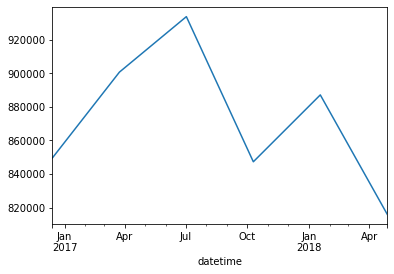

In [108]:
splited = splitById(0, Raw_train)

splited['amount'].resample('100D').sum().plot()